### Project Goal:

**The objective of this project is to assist OilyGiant Mining Company in identifying the most profitable and low-risk region for developing a new oil well.**

**To achieve this, we:**

- **Analyzed geological exploration data from three potential regions,**
- **Built and evaluated linear regression models to predict oil reserves,**
- **Estimated profits for the top 200 wells in each region,**
- **And applied the bootstrapping technique to assess risk and confidence in the predictions.**

### Load and prepare the datasets

In [1]:
import pandas as pd 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#load the datasets
data_0= pd.read_csv("/datasets/geo_data_0.csv")
data_1= pd.read_csv("/datasets/geo_data_1.csv")
data_2= pd.read_csv("/datasets/geo_data_2.csv")

# Store in a dictionary for easier iteration
datasets = {'Region 0': data_0, 'Region 1': data_1, 'Region 2': data_2}

#defining constants values
BUDGET = 100000000 
WELL_COUNT = 200 # number of wells to develop
REVENUE_PER_BARREL = 4.5 
REVENUE_PER_1000_BARRELS = REVENUE_PER_BARREL * 1000

In [3]:
# Quick overview for all the dataframes to inspect the data
for i, data in datasets.items():
    print(f"Region {i}")
    display(data.info())
    display(data.describe())
    display('Missing valuse :',data.isna().sum())
    print("="*60)

Region Region 0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


'Missing valuse :'

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

Region Region 1
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


'Missing valuse :'

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

Region Region 2
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


'Missing valuse :'

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

In [4]:
# Reviewer's code 2

display(data_0.head())

data_0.tail()

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


,id,f0,f1,f2,product
99995,DLsed,0.971957,0.370953,6.075346,110.744026
99996,QKivN,1.392429,-0.382606,1.273912,122.346843
99997,3rnvd,1.029585,0.018787,-1.348308,64.375443
99998,7kl59,0.998163,-0.528582,1.583869,74.040764
99999,1CWhH,1.764754,-0.266417,5.722849,149.633246


In [5]:
# Check correlation with target for each region
for i, data in datasets.items():
    print(f"Region {i} correlations:")
    print(data.corr()['product'].sort_values(ascending=False))
    print("="*60)

Region Region 0 correlations:
product    1.000000
f2         0.483663
f0         0.143536
f1        -0.192356
Name: product, dtype: float64
Region Region 1 correlations:
product    1.000000
f2         0.999397
f1        -0.010155
f0        -0.030491
Name: product, dtype: float64
Region Region 2 correlations:
product    1.000000
f2         0.445871
f1        -0.001012
f0        -0.001987
Name: product, dtype: float64


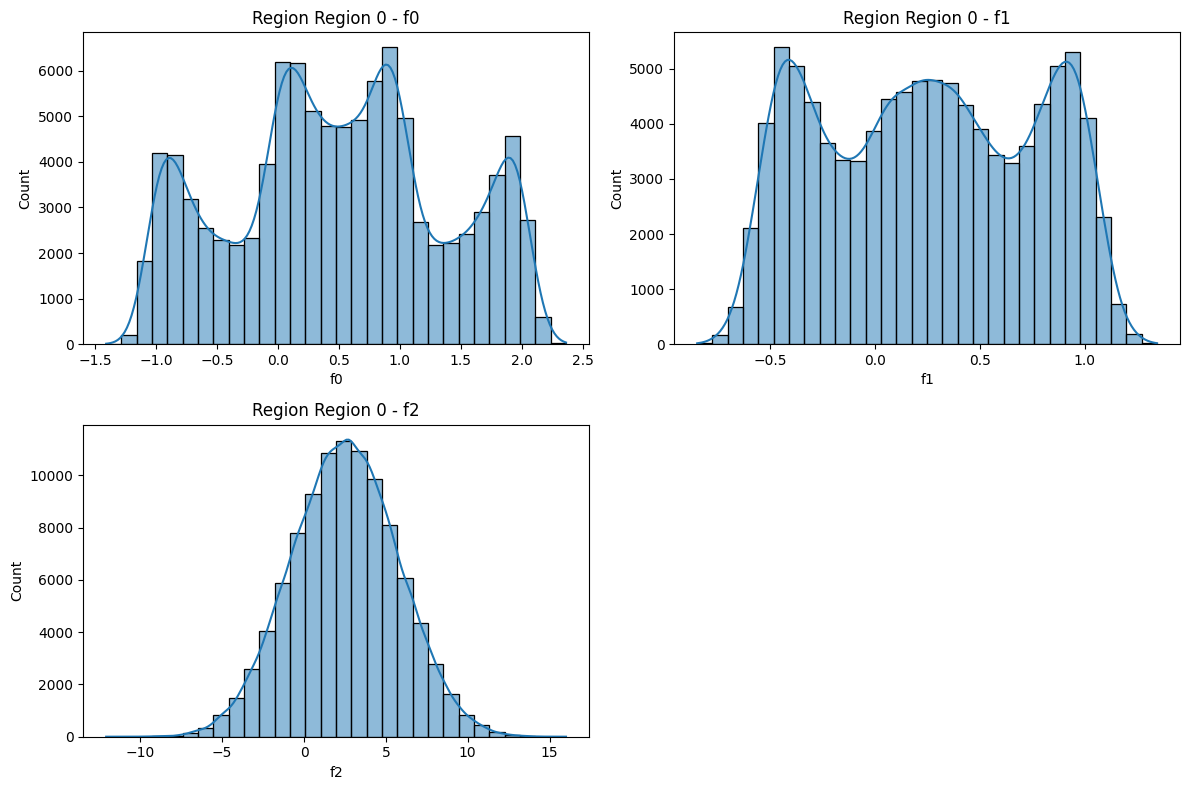

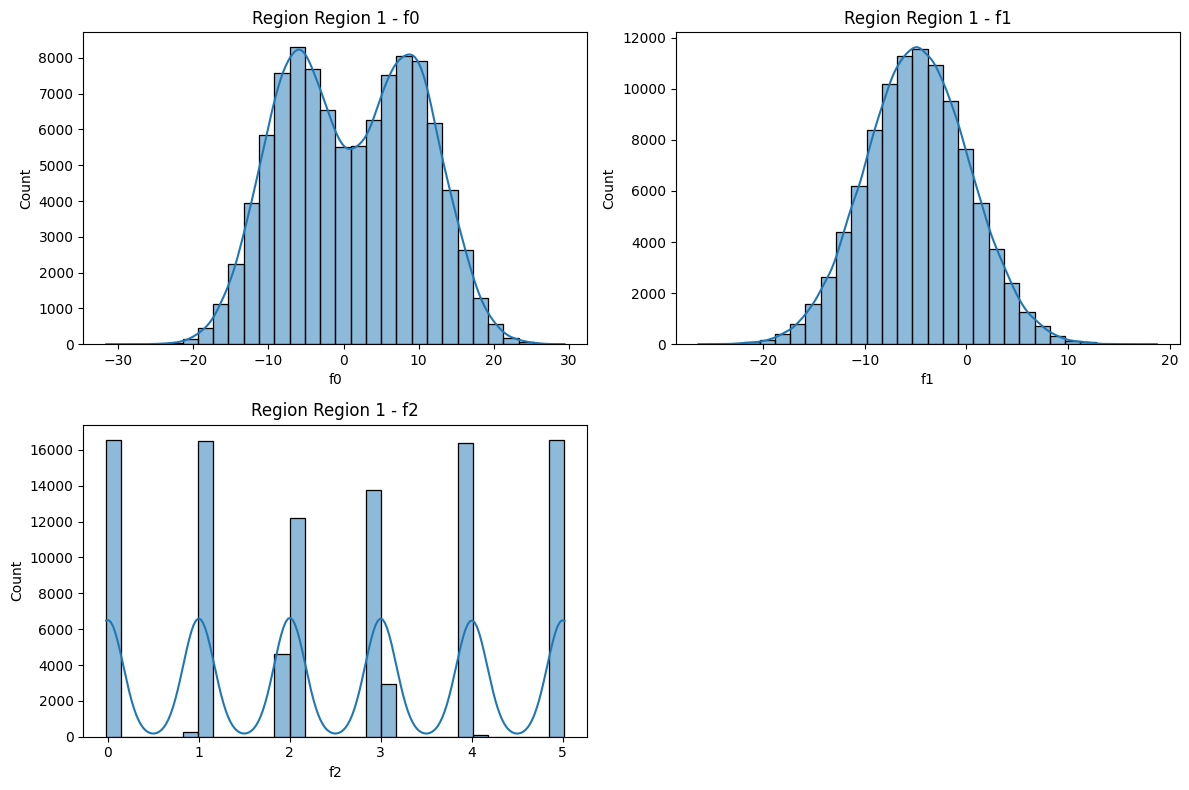

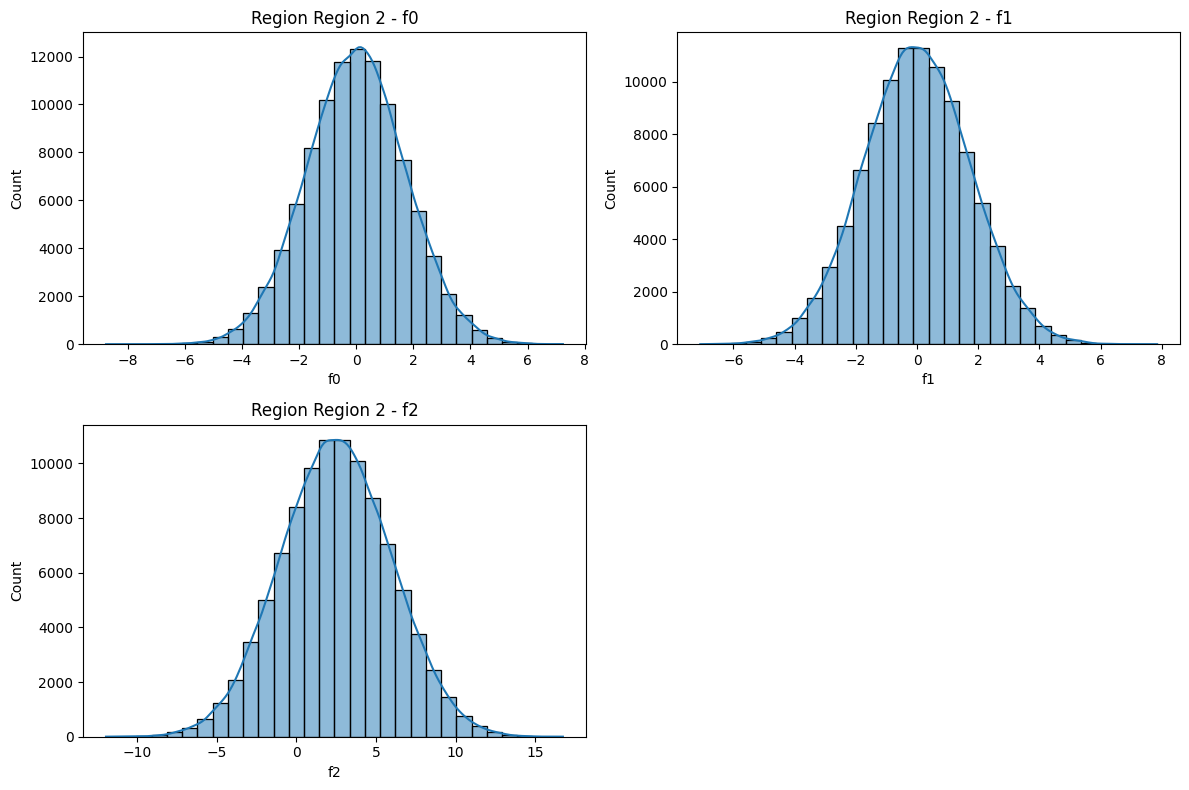

In [6]:
#Analyze the distributions of features and targets
def plot_distributions(data, region_name):
    plt.figure(figsize=(12, 8))
    features_plt = data.drop(columns=['id', 'product'])
    for i, col in enumerate(features_plt):
        plt.subplot(2, 2, i+1)
        sns.histplot(data[col], kde=True, bins=30)
        plt.title(f'{region_name} - {col}')
    plt.tight_layout()
    plt.show()

for i, data in datasets.items():
    plot_distributions(data, f'Region {i}')
    

In [7]:
#Check for duplicates
for i, data in datasets.items():
    duplicates = data.duplicated().sum()
    print(f"Region {i} has {duplicates} duplicate rows.")
    

Region Region 0 has 0 duplicate rows.
Region Region 1 has 0 duplicate rows.
Region Region 2 has 0 duplicate rows.


**Summary:**
**We analyzed The data was clean, with no duplicates. Feature and target distributions varied across regions, justifying separate analysis.and the correlation between features (f0, f1, f2) and the target product in each region. In Region 0, f2 showed the strongest correlation with the target. We evaluated the correlation between the features and the target (product) for each region. In all regions, f2 is the most informative feature, with particularly strong correlation in Region 1 (0.999) and moderate correlation in Regions 0 (0.48) and 2 (0.45). Features f0 and f1 showed weak or negative correlation with the target and are unlikely to significantly improve model performance. This suggests that f2 will be the primary driver of prediction accuracy in all three models.**

### Train and test the model for all regions

In [44]:
#Train and Test the Model for Each Region
#stor the results
results = {}

#loop over each regoin
for name, data in datasets.items():
    print(f"\n {name}")

    #Separate the data to features and target 
    #and drop "id" column becuase it is unique identifier and not useful for training
    features = data.drop(columns=['id', 'product'])
    target = data['product']

    #split to training sets and valid sets 
    features_train ,features_valid, target_train, target_valid  = train_test_split(features, target, test_size=0.25, random_state=12345)

    #train the model
    model = LinearRegression()
    model.fit(features_train, target_train)
    
    pred = model.predict(features_valid)
    
    #Calculate average predicted volume and RMSE
    mean_pred = pred.mean()
    rmse = mean_squared_error(target_valid, pred, squared=False)

    print(f"Average predicted volume: {mean_pred:.2f}")
    print(f"RMSE: {rmse:.2f}")

    
    results[name] = {
        'model': model,
        'predictions': pred,
        'features_valid': features_valid,
        'target_valid':target_valid,
        'rmse': rmse,
        'mean_prediction': mean_pred,
        'target':target
    }


 Region 0
Average predicted volume: 92.59
RMSE: 37.58

 Region 1
Average predicted volume: 68.73
RMSE: 0.89

 Region 2
Average predicted volume: 94.97
RMSE: 40.03


**Region 1 is the most promising region for further analysis, investment,
Best model performance (lowest RMSE) and Highest feature-product correlation**

### Prepare for Profit Calculation

**We'll define key financial parameters, calculate the break-even point (minimum product volume per well needed to avoid losses), and compare it with each region’s average predicted volume**

In [45]:
#I defined now the constants values in the beginning of the project

In [46]:
#Calculate the Break-Even Point
# Volume per well needed to break even
break_even_volume = BUDGET / (WELL_COUNT * REVENUE_PER_1000_BARRELS)
print(f"Break-even volume per well: {break_even_volume:.2f} thousand barrels")

Break-even volume per well: 111.11 thousand barrels


In [47]:
#Compare to Average Predicted Volumes
for region_name, region_data in results.items():
    avg_target = region_data['target'].mean()
    print(f"{region_name.title()}:")
    print(f"  Avg Target volume: {avg_target:.2f} thousand barrels")
    print(f"  Break-even required: {break_even_volume:.2f} thousand barrels")
    if avg_target >= break_even_volume:
        print(" Meets or exceeds break-even point.\n")
    else:
        print(" Below break-even point.\n")

Region 0:
  Avg Target volume: 92.50 thousand barrels
  Break-even required: 111.11 thousand barrels
 Below break-even point.

Region 1:
  Avg Target volume: 68.83 thousand barrels
  Break-even required: 111.11 thousand barrels
 Below break-even point.

Region 2:
  Avg Target volume: 95.00 thousand barrels
  Break-even required: 111.11 thousand barrels
 Below break-even point.



**We used the stored results dictionary from Step 2 to compare each region’s average target oil reserves with the calculated break-even volume of 111.11 thousand barrels per well. All three regions fell below the break-even threshold, indicating a potential risk of financial loss unless the most productive wells are selectively developed**

### Profit Calculation Function

In [48]:
def calculate_profit(predictions, targets):
    # Select top 200 predicted wells
    top_200_indices = predictions.sort_values(ascending=False).index[:200]
    
    # Get actual product values (not predicted ones) of selected wells
    selected_targets = targets.loc[top_200_indices]
    
    # Total profit: 4500 USD per 1000 barrels
    revenue_per_thousand_barrels = 4.5 * 1000
    total_revenue = selected_targets.sum() * revenue_per_thousand_barrels
    # Net profit = revenue - budget
    total_profit = total_revenue - BUDGET
    return total_profit

In [49]:
for region_name, region_data in results.items():
    target = region_data['target_valid']
    predictions = pd.Series(region_data['predictions'], index=target.index)
    
    profit = calculate_profit(predictions, target)
    print(f"{region_name.title()} - Profit from top 200 wells: ${profit:,.0f}")

Region 0 - Profit from top 200 wells: $33,208,260
Region 1 - Profit from top 200 wells: $24,150,867
Region 2 - Profit from top 200 wells: $27,103,500


**Region 0 shows the highest potential profit among all three regions when selecting the top 200 wells, making it the strongest**

### Risk and Profit Analysis with Bootstrapping

In [50]:
def bootstrap_profit(predictions, target, n_samples=1000, wells_count=200):
    state = np.random.RandomState(12345)
    values = []

    predictions = pd.Series(predictions, index=target.index)

    for _ in range(n_samples):
        # Randomly sample 500 wells with replacement
        sample_indices = state.choice(predictions.index, size=500, replace=True)
        
        # Select top 200 predictions from the sample
        top_200 = predictions.loc[sample_indices].sort_values(ascending=False).head(wells_count).index
        
        # Use actual target values for profit calculation
        selected_targets = target.loc[top_200]
        profit = selected_targets.sum() * 4.5 * 1000  # $4.5k per thousand barrels
        values.append(profit)

    values = pd.Series(values)
    return values

In [55]:
#Apply Bootstrapping to All Regions
bootstrap_results = {}

for region_name, region_data in results.items():
    targets = region_data['target_valid']
    predictions = pd.Series(region_data['predictions'], index=targets.index)
    
    revenues = bootstrap_profit(predictions, targets)
    profits = revenues - BUDGET
    mean_profit = profits.mean()
    lower = profits.quantile(0.025)
    upper = profits.quantile(0.975)
    risk = (profits < 0).mean() * 100  # percent risk

    bootstrap_results[region_name] = {
        'mean_profit': mean_profit,
        'ci_lower': lower,
        'ci_upper': upper,
        'risk': risk
    }

    print(f"{region_name.title()}:")
    print(f"  Average Profit: ${mean_profit:,.0f}")
    print(f"  95% CI: (${lower:,.0f}, ${upper:,.0f})")
    print(f"  Risk of Loss: {risk:.2f}%")
    print("-" * 50)

Region 0:
  Average Profit: $3,961,650
  95% CI: ($-1,112,155, $9,097,669)
  Risk of Loss: 6.90%
--------------------------------------------------
Region 1:
  Average Profit: $4,560,451
  95% CI: ($338,205, $8,522,895)
  Risk of Loss: 1.50%
--------------------------------------------------
Region 2:
  Average Profit: $4,044,039
  95% CI: ($-1,633,504, $9,503,596)
  Risk of Loss: 7.60%
--------------------------------------------------


**All three regions present positive average profits, but they carry varying levels of financial risk:**

- **Region 1 demonstrates the highest average profit ($4.56M) and the lowest risk of loss at just 1.5%, with a fully positive 95% confidence interval, making it the most stable and attractive option.**
- **Region 0 and Region 2, while also profitable, show higher risks of loss (6.9% and 7.6% respectively), and their confidence intervals include negative values, indicating a greater chance of investment loss.**
  
- **Given these insights, Region 1 is the recommended location for new oil well development due to its optimal balance of strong average returns and minimal risk**

### Final Conclusion :

**In this project, we analyzed geological exploration data from three regions to determine the most profitable and least risky location for developing new oil wells for OilyGiant Mining Company. The analysis followed a structured, data-driven approach:**

- Linear regression models were trained for each region to predict oil production volume based on geological features.
- We assessed model performance using Root Mean Squared Error (RMSE) and average predicted reserves, revealing differences in prediction accuracy between regions.
- Using the trained models, we selected the top 200 predicted wells in each region and calculated expected profits based on actual oil production (target values).
- We applied bootstrapping to simulate thousands of investment outcomes per region, allowing us to estimate 95% confidence intervals for profits and the risk of financial loss.
  
**Based on the results, Region 1 emerged as the most attractive investment choice, offering the highest average profit and the lowest risk (1.5%), with a confidence interval fully above break-even. While Regions 0 and 2 also show profit potential, they carry higher uncertainty and risk of loss.**

- **Recommendation:** Proceed with oil well development in Region 1, as it offers the best trade-off between profitability and risk under the current business constraints.